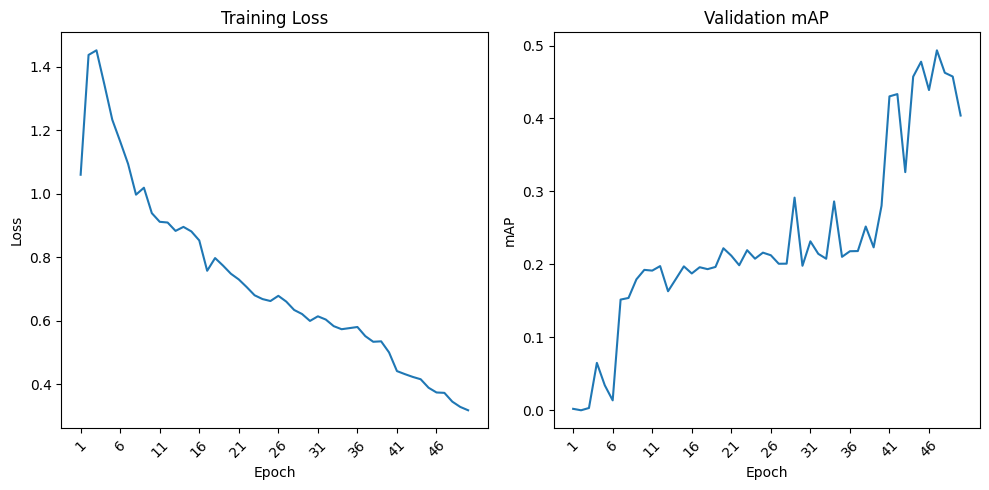

Best accuracy: 0.49342 at epoch 47


In [2]:
import matplotlib.pyplot as plt

losses = []
accuracies = []

# Losses and accurances are stored in the results.csv file in the save_dir
with open("chkpts/ART/yolov8x-semiseg-artnet3/results.csv") as file:
    lines = file.readlines()
    losses = [float(line.split(",")[1]) for line in lines[1:]]
    accuracies = [float(line.split(",")[7]) for line in lines[1:]]    

# Plot the training loss and validation mAP
plt.figure(figsize=(10, 5))
# Epoch starts at 1 and are all integers
epochs = range(1, len(losses) + 1)
epochs = [int(epoch) for epoch in epochs]
plt.subplot(1, 2, 1)
plt.xticks(epochs[::5], rotation=45)
plt.plot(epochs, losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.xticks(epochs[::5], rotation=45)
plt.plot(epochs, accuracies)
plt.title("Validation mAP")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.tight_layout()
plt.savefig("results/ART/metrics.png")
plt.show()

# output best accuracy and epoch
best_accuracy = max(accuracies)
best_epoch = accuracies.index(best_accuracy) + 1
print(f"Best accuracy: {best_accuracy} at epoch {best_epoch}")

50 epochs completed in 4.264 hours.

In [3]:
import os
import random
import shutil
from pathlib import Path

random.seed(42)

# Define paths
base_path = "D:/Data/ART-Net/"
folders = ["images", "labels", "masks", "tool_tip_masks"]
train_folder = "train"
val_folder = "val"
val_split = 0.15

# Create validation folders if they do not exist
for folder in folders:
    os.makedirs(os.path.join(base_path, folder, val_folder), exist_ok=True)

# Get list of all files in the train folders (using images as reference)
train_images_path = os.path.join(base_path, "images", train_folder)
all_files = [
    f
    for f in os.listdir(train_images_path)
    if os.path.isfile(os.path.join(train_images_path, f))
]

# Determine the number of validation samples
num_val_samples = int(len(all_files) * val_split)

# Randomly select files for the validation set
val_files = random.sample(all_files, num_val_samples)

# Move selected files to the validation folders
for folder in folders:
    train_path = os.path.join(base_path, folder, train_folder)
    val_path = os.path.join(base_path, folder, val_folder)

    for file in val_files:
        file_name, file_ext = os.path.splitext(file)

        # Find corresponding file (allowing for different extensions)
        corresponding_file = None
        for ext in [".png", ".npy", ".txt"]:
            if os.path.exists(os.path.join(train_path, file_name + ext)):
                corresponding_file = file_name + ext
                break

        if corresponding_file:
            shutil.move(
                os.path.join(train_path, corresponding_file),
                os.path.join(val_path, corresponding_file),
            )

print("Validation set created with {} samples.".format(num_val_samples))

Validation set created with 297 samples.


In [11]:
dataset_path = "D:/Data/ART-Net/"

# Create a configuration file for YOLOv8
config_content = f"""
train: {dataset_path}/images/train
val: {dataset_path}/images/val

nc: 1  # number of classes
names: ['tool']  # class names
"""

# config_content = f"""
# train: {dataset_path}/images/train
# val: {dataset_path}/images/val

# nc: 1  # number of classes
# names: ['tool']  # class names
# """

config_path = os.path.join(dataset_path, "data.yaml")
with open(config_path, "w") as file:
    file.write(config_content)

In [12]:
# Create a configuration file for YOLOv8 test
config_content_test = f"""
train: {dataset_path}/images/train
val: {dataset_path}/images/test

nc: 1  # number of classes
names: ['tool']  # class names
"""
config_path_test = os.path.join(dataset_path, "data-test.yaml")
with open(config_path_test, "w") as file:
    file.write(config_content_test)

In [13]:
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from multiprocessing import freeze_support
import torch

print(torch.cuda.is_available())
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = YOLO("chkpts/ART/yolov8x-semiseg-artnet3/weights/best.pt")
model.to(device)
results = model.val(data=config_path_test)

True
2.2.1+cu121
cuda
YOLOv8x-seg summary (fused): 295 layers, 71721619 parameters, 0 gradients, 343.7 GFLOPs


val: Scanning D:\Data\ART-Net\labels\test.cache... 154 images, 0 backgrounds, 0 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


                   all        154        768      0.992      0.201      0.493      0.458      0.992      0.201      0.493      0.436
Speed: 0.3ms preprocess, 37.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\segment\val


    Calculates and aggregates detection and segmentation metrics over a given set of classes.

    Args:
        save_dir (Path): Path to the directory where the output plots should be saved. Default is the current directory.
        plot (bool): Whether to save the detection and segmentation plots. Default is False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (list): List of class names. Default is an empty list.

    Attributes:
        save_dir (Path): Path to the directory where the output plots should be saved.
        plot (bool): Whether to save the detection and segmentation plots.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (list): List of class names.
        box (Metric): An instance of the Metric class to calculate box detection metrics.
        seg (Metric): An instance of the Metric class to calculate mask segmentation metrics.
        speed (dict): Dictionary to store the time taken in different phases of inference.

    Methods:
        process(tp_m, tp_b, conf, pred_cls, target_cls): Processes metrics over the given set of predictions.
        mean_results(): Returns the mean of the detection and segmentation metrics over all the classes.
        class_result(i): Returns the detection and segmentation metrics of class `i`.
        maps: Returns the mean Average Precision (mAP) scores for IoU thresholds ranging from 0.50 to 0.95.
        fitness: Returns the fitness scores, which are a single weighted combination of metrics.
        ap_class_index: Returns the list of indices of classes used to compute Average Precision (AP).
        results_dict: Returns the dictionary containing all the detection and segmentation metrics and fitness score.

In [28]:
results.results_dict

{'metrics/precision(B)': 0.9916738193314167,
 'metrics/recall(B)': 0.20052083333333334,
 'metrics/mAP50(B)': 0.49341713630933315,
 'metrics/mAP50-95(B)': 0.458005100836112,
 'metrics/precision(M)': 0.9916738193314167,
 'metrics/recall(M)': 0.20052083333333334,
 'metrics/mAP50(M)': 0.49341713630933315,
 'metrics/mAP50-95(M)': 0.43551871228967187,
 'fitness': 0.9028548590750721}

In [ ]:
# results = model.track("/Volumes/Exodus/Data/6DOF 2023/Test 1/Dataset.mp4", tracker="bytetrack.yaml", save=True, show=True)

results = model.track(
    "data/6DOF/Dataset.mp4",
    tracker="bytetrack.yaml",
    save=True,
    show=True,
)

# results = model.track(
#     "/Volumes/Exodus/Data/EndoVis 2015/Tracking (Raw Video)/Dataset1/Video.avi",
#     tracker="bytetrack.yaml",
#     save=True,
#     show=True,
# )

In [ ]:
import numpy as np
import torch

# Function to remove overlapping boxes using Non-Max Suppression
def non_max_suppression(boxes, scores, iou_threshold):
    if len(boxes) == 0:
        return []

    # Convert to numpy arrays
    boxes = np.array(boxes)
    scores = np.array(scores)

    # Compute areas of each box
    areas = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    order = scores.argsort()[::-1]  # Sort by score in descending order

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        if order.size == 1:
            break
        xx1 = np.maximum(boxes[i, 0], boxes[order[1:], 0])
        yy1 = np.maximum(boxes[i, 1], boxes[order[1:], 1])
        xx2 = np.minimum(boxes[i, 2], boxes[order[1:], 2])
        yy2 = np.minimum(boxes[i, 3], boxes[order[1:], 3])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter = w * h

        iou = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(iou <= iou_threshold)[0]
        order = order[inds + 1]

    return keep


def process_image(image_path, file, model, iou_threshold=0.3, confidence_threshold=0.5, max_boxes=2):
    # Perform inference on a new image
    results = model(image_path, save=False, show=False, verbose=False)

    # Extract the results
    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()

    # Step 1: Filter out boxes with confidence scores less than the threshold
    filtered_indices = np.where(scores >= confidence_threshold)[0]
    filtered_boxes = boxes[filtered_indices]
    filtered_scores = scores[filtered_indices]

    # Step 2: Remove overlapping boxes using Non-Max Suppression
    nms_indices = non_max_suppression(filtered_boxes, filtered_scores, iou_threshold)

    # Keep only the top boxes
    top_indices = nms_indices[:max_boxes]

    # Update results with filtered boxes
    results[0].boxes = results[0].boxes[top_indices]

    # Display the results
    # results[0].show()

    # Store image in tmp
    tmp = "tmp/" + file.replace(".bmp", "_tmp.png")
    results[0].save(tmp)

# test_dir = "/Volumes/Exodus/Data/6DOF 2023/Test 1/"
test_dir = "/Volumes/Exodus/Data/EndoVis 2015/Testing (Raw Images)/OP1/"

# For all bmp files
for file in sorted(os.listdir(test_dir)):
    if file.endswith(".png") and not file.startswith("._"):
        test_path = os.path.join(test_dir, file)
        process_image(test_path, file, model)

In [ ]:
import imageio.v2 as imageio


# Combine all bmp files to video
# Create video from BMP files
def stitch_images(bmp_directory, output_video_path):
    # List all BMP files in the directory
    bmp_files = sorted(
        [
            os.path.join(bmp_directory, f)
            for f in os.listdir(bmp_directory)
            if f.endswith(".png") and not f.startswith(".")
        ]
    )

    # Create a video writer object
    with imageio.get_writer(output_video_path, fps=24) as writer:
        for file_path in bmp_files:
            image = imageio.imread(file_path)
            writer.append_data(image)

    print(f"Video saved at {output_video_path}")


output_image_name = "results/Test 1/yolo8-1.mp4"

# Stitch the images together
# stitch_images("tmp", output_image_name)

In [ ]:
# Use label file to draw original bounding box on original image
sample_label = "/Volumes/Exodus/Data/ART-Net/labels/val/Test_Pos_sample_0001.txt"
sample_image = (
    "/Volumes/Exodus/Data/ART-Net/Test/Test_Positive/Test_Pos_sample_0001.png"
)

# Draw plot with two images, one of sample image and one with results[0]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
image = cv2.imread(sample_image)
with open(sample_label, "r") as lf:
    for line in lf:
        label = line.strip().split(" ")
    x_center, y_center, width, height = map(float, label[1:])
    image = cv2.imread(sample_image)
    x = int((x_center - width / 2) * image.shape[1])
    y = int((y_center - height / 2) * image.shape[0])
    w = int(width * image.shape[1])
    h = int(height * image.shape[0])
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

# plt.subplot(1, 2, 2)
# save image
# results[0].save("tmp/results.png")
# # display image
# plt.imshow(cv2.cvtColor(cv2.imread("tmp/results.png"), cv2.COLOR_BGR2RGB))
# plt.axis("off")
# plt.show()